# Кодирование пар

In [1]:
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer(language="russian")

In [2]:
def LCS_string(s1, s2):
    s1 = snowball.stem(s1)
    s2 = snowball.stem(s2)
    
    d = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]
    max_val, index_i = 0, 0
    for i in range(len(s1) + 1):
        for j in range(len(s2) + 1):
            if i and j and s1[i - 1] == s2[j - 1]:
                d[i][j] = d[i - 1][j - 1] + 1
            if d[i][j] > max_val:
                max_val = d[i][j]
                index_i = i
                index_j = j
    
    return s1[index_i - max_val : index_i]

In [3]:
arr_ru = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 
          'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я', '*']
codes = dict(zip(arr_ru, range(len(arr_ru))))

print(codes)

{'а': 0, 'б': 1, 'в': 2, 'г': 3, 'д': 4, 'е': 5, 'ё': 6, 'ж': 7, 'з': 8, 'и': 9, 'й': 10, 'к': 11, 'л': 12, 'м': 13, 'н': 14, 'о': 15, 'п': 16, 'р': 17, 'с': 18, 'т': 19, 'у': 20, 'ф': 21, 'х': 22, 'ц': 23, 'ч': 24, 'ш': 25, 'щ': 26, 'ь': 27, 'ы': 28, 'ъ': 29, 'э': 30, 'ю': 31, 'я': 32, '*': 33}


In [4]:
from string import punctuation

def encode(s1, s2):
    s1 = s1.lower()
    s2 = s2.lower()
    s1 = ''.join([c for c in s1 if c not in punctuation])
    s2 = ''.join([c for c in s2 if c not in punctuation])
    
    lcs_str = LCS_string(s1, s2)
    ind1 = s1.find(lcs_str)
    ind2 = s2.find(lcs_str)
    
    pref_len = max(ind1, ind2)
    suff_len = max(len(s1) - ind1, len(s2) - ind2)
    
    code1 = [0] * (pref_len + suff_len)
    code2 = [0] * (pref_len + suff_len)
    
    for i in range(pref_len + suff_len):
        if i - (pref_len - ind1) < 0 or i - (pref_len - ind1) >= len(s1):
            code1[i] = codes['*']
        else:
            code1[i] = codes[s1[i - (pref_len - ind1)]]
            
        if i - (pref_len - ind2) < 0 or i - (pref_len - ind2) >= len(s2):
            code2[i] = codes['*']
        else:
            code2[i] = codes[s2[i - (pref_len - ind2)]]
    
    pair_code = [code1[i] * len(arr_ru) + code2[i] for i in range(pref_len + suff_len)]
    
    return pair_code

In [5]:
print(encode('абаа', 'бабаб'))

[1123, 0, 35, 0, 1]


Загрузим данные, закодируем пары слов:

In [6]:
import pandas as pd

data = pd.read_csv('final_balanced_cognates_dataset.csv', encoding='cp1251')

In [7]:
data['pair_code'] = data.apply(lambda row: encode(row.first_word, row.second_word), axis=1)
data.head()

,Unnamed: 0,first_word,second_word,Levenshtein,longest_common_substr,longest_common_subs,class,Levenshtein_stemmed,LCS_stemmed,Levenshtein_similarity,before_lcs,after_lcs,pair_code
0,1590,Кровососущий,Соплеменный,10,1,2,0,9,2,0.111111,6,5,"[407, 611, 543, 101, 543, 630, 525, 628, 692, ..."
1,955209,Затюкать,Досушить,6,2,2,0,6,0,0.166667,0,0,"[276, 15, 664, 1074, 399, 9, 665, 945]"
2,1062544,Метелить,Затечь,5,2,3,0,3,2,0.333333,0,2,"[450, 170, 665, 175, 432, 333, 679, 951]"
3,607664,Калевать,Натравляться,8,2,4,0,6,1,0.166667,0,4,"[388, 0, 427, 187, 68, 2, 658, 950, 1141, 1149..."
4,802046,Уваляться,Валивать,7,2,4,1,4,3,0.250000,2,1,"[713, 70, 0, 420, 1097, 648, 918, 631, 1115]"


In [8]:
data['code_len'] = data.apply(lambda row: len(row.pair_code), axis=1)
max_len_code = data['code_len'].max()
print(max_len_code)

38


# Построение модели

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

X = pad_sequences(data['pair_code'], maxlen=max_len_code)
y = utils.to_categorical(data['class'], num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [11]:
X_train

array([[   0,    0,    0, ..., 1136, 1150, 1132],
       [   0,    0,    0, ...,  927,  666, 1140],
       [   0,    0,    0, ...,  923,  624, 1097],
       ...,
       [   0,    0,    0, ...,  597,  503, 1121],
       [   0,    0,    0, ...,  155,  606, 1132],
       [   0,    0,    0, ...,  794,  321, 1091]])

In [12]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Bidirectional, LSTM

model = Sequential()
pair_count = len(arr_ru) * len(arr_ru)
model.add(Embedding(input_dim=pair_count, output_dim=32, input_length=max_len_code))
model.add(Conv1D(filters=32, kernel_size=5, padding='valid', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=5, padding='valid', activation='relu'))
model.add(Conv1D(filters=32, kernel_size=5, padding='valid', activation='relu'))
model.add(Bidirectional(LSTM(units=8)))
model.add(Dense(units=2, activation='softmax'))

In [14]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 38, 32)            36992     
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 32)            5152      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 32)            5152      
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                2624      
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 55,106
Trainable params: 55,106
Non-trainable params: 0
____________________________________________________

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_save_path = 'cognates_model_first.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [17]:
history = model.fit(X_train, 
                    y_train,
                    epochs=5,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/5
27816/27816 [==============================] - 445s 16ms/step - loss: 0.0877 - accuracy: 0.9719 - val_loss: 0.0418 - val_accuracy: 0.9879

Epoch 00001: val_accuracy improved from -inf to 0.98792, saving model to cognates_model_first.h5
Epoch 2/5
27816/27816 [==============================] - 405s 15ms/step - loss: 0.0363 - accuracy: 0.9897 - val_loss: 0.0373 - val_accuracy: 0.9892

Epoch 00002: val_accuracy improved from 0.98792 to 0.98916, saving model to cognates_model_first.h5
Epoch 3/5
27816/27816 [==============================] - 350s 13ms/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.0320 - val_accuracy: 0.9907

Epoch 00003: val_accuracy improved from 0.98916 to 0.99073, saving model to cognates_model_first.h5
Epoch 4/5
27816/27816 [==============================] - 376s 14ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 0.0346 - val_accuracy: 0.9899

Epoch 00004: val_accuracy did not improve from 0.99073
Epoch 5/5
27816/27816 [=============================

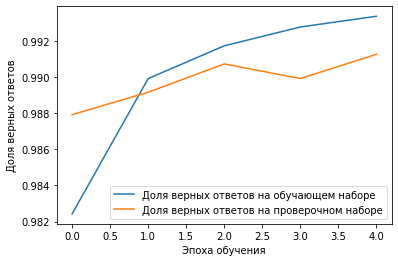

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

prediction = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1), prediction.argmax(axis=1), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99    123271
     class 1       0.99      0.99      0.99    123982

    accuracy                           0.99    247253
   macro avg       0.99      0.99      0.99    247253
weighted avg       0.99      0.99      0.99    247253

